In [10]:
import numpy as np
import pandas as pd

import geopandas as gpd
import shapely.wkt
from shapely import geometry
import geojson
from shapely.geometry import shape
from shapely.wkt import loads

import re

import sys, os, time
import glob

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import pickle
import copy

colormap = {"bldg":"black", "pop":"green", "lum":"orange", 
            "all":"blue", "bnds":"gray"}

cmap_bld = sns.light_palette("black", n_colors=10)
cmap_pop = sns.light_palette("green", n_colors=10)
cmap_lum = sns.light_palette("orange",n_colors=10)


cmap_dict = {"bldg":ListedColormap(cmap_bld), 
             "pop":ListedColormap(cmap_pop), 
             "lum":ListedColormap(cmap_lum)}


In [3]:
import pickle
import gzip

# pickle with stats dictionary
stats_file_path = "C:/Users/bramv/OneDrive - Square Four/Documenten/Leiden/23-24/urban computing/urbanization-patterns-master./urbanization-patterns-master/pysatml/home/data/world-cities/spatial-maps/stats_cities_over10kpop.pickle.gz"

# Open the file using gzip for reading
with open(stats_file_path, "rb") as f:
    cities = pickle.load(f)

print(len(cities))

10


In [4]:
# add specific info which did not come with the original data
mycities = [("paris", "france")]

cities_smpl = {}
for c in mycities:
    for k, v in cities.items():
        if 'city' not in v:
            v['city'] = c[0]
        if 'country' not in v:
            v['country'] = c[1]
        if 'population' not in v:
            v['population'] = 2200000
            v['size'] = 'large'
        cities_smpl[v['city']] = {
            'name': v['city'],
            'country': v['country'],
            'data': (v, k),
        }


In [5]:
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
# import resize skimage.transform.resize
from skimage.transform import resize

def get_image_data(city_info, imgSize=None, take_log=False):
    fname = files_dict[city_info]
    img = imread(fname)
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    f = np.log if take_log else lambda x: x
    mask = img[...,3]==0
    for i in range(3):
        img[...,i] = f(img[...,i]); img[...,i][mask] = np.nan
        img[...,i] = (img[...,i] - np.nanmin(img[...,i])) / float((np.nanmax(img[...,i]) - np.nanmin(img[...,i])))
    return {'bldg':img[...,0], 
            'pop':img[...,1], 
            'lum':img[...,2], 
            'wtr':mask,
            'bnd':img[...,4]} 

def format_pop(pop):
    if pop > 1e6:
        div = 1e6
        s = 'M'
    else:
        div = 1e3
        s = 'k'
    return "%2.1f%s"%(float(pop)/div, s)

import matplotlib.cm as cm

def overlay_mask(img, mask, ax, alpha=0.1, cmap=cm.GnBu):
    masked_data = np.ma.masked_where(mask, img)
    # Overlay the two images
    ax.imshow(img, cmap=cmap)
    ax.imshow(masked_data, cmap=cm.gray, interpolation='none', alpha=alpha)

In [6]:
import numpy as np
import pandas as pd

# get everything out of the dictionary into a dataframe

paris_data = cities

# Extracting scales_within data
scales_within = np.array([
    paris_data.get('avg_area_bnds', {}).get('built', np.nan),
    paris_data.get('population', np.nan),
    paris_data.get('avg_area_bnds', {}).get('lum', np.nan)
]).reshape(1, -1)

# Extracting scales_total data
scales_total = np.array([
    paris_data.get('avg_area', {}).get('built', np.nan),
    paris_data.get('sum_area', {}).get('pop', np.nan),
    paris_data.get('avg_area', {}).get('lum', np.nan)
]).reshape(1, -1)

# Extracting scales_max data
scales_max = np.array([
    np.nanmax(paris_data.get('profiles', {}).get('built', [np.nan])),
    np.nanmax(paris_data.get('profiles', {}).get('pop', [np.nan])),
    np.nanmax(paris_data.get('profiles', {}).get('lum', [np.nan]))
]).reshape(1, -1)

# Combine all scales data
scales = np.hstack([scales_within, scales_total, scales_max])

# Define columns for scales_df
columns_scales = ["bldg-in", "pop-in", "lum-in",
                  "bldg-tot", "pop-tot", "lum-tot",
                  "bldg-max", "pop-max", "lum-max"]

# Create scales_df
scales_df = pd.DataFrame(scales, columns=columns_scales)

# Create info_df for Paris
info_df = pd.DataFrame({
    'city': [paris_data.get('city')],
    'country': [paris_data.get('country', '')],
    'population': [int(float(paris_data.get('population', 0)))],
    'scale-pop': [paris_data.get('size', '')]
})

# Concatenate info_df and scales_df
result_df = pd.concat([info_df, scales_df], axis=1)

result_df.fillna(0, inplace=True)  # Fill NaN values with 0

result_df.head()


,city,country,population,scale-pop,bldg-in,pop-in,lum-in,bldg-tot,pop-tot,lum-tot,bldg-max,pop-max,lum-max
0,0,,0,,148.602574,0.0,1.0,13.514113,14762042.0,0.568988,134.490979,19949.875,1.0


In [7]:
# add stuff again 
result_df['city'] = 'paris'
result_df['country'] = 'france'
result_df['population'] = 2200000
result_df['scale-pop'] = 'large'
result_df['pop-in'] = 2200000.0

result_df.head()

,city,country,population,scale-pop,bldg-in,pop-in,lum-in,bldg-tot,pop-tot,lum-tot,bldg-max,pop-max,lum-max
0,paris,france,2200000,large,148.602574,2200000.0,1.0,13.514113,14762042.0,0.568988,134.490979,19949.875,1.0


# analyze discrepancy

Analysis only on the data gathered from the statistics we calculated earlier, and saved to the pickle file.

In [8]:
from pyemd import emd, emd_with_flow
from scipy.linalg import toeplitz

def find_sign_change_array(a):
    asign = np.sign(a)
    sz = asign == 0
    if sz.any():
        asign[sz] = np.roll(asign, 1)[sz]
        sz = asign == 0
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0] = 0
    return signchange

def get_regions(a):
    sgn = find_sign_change_array(a)
    regs= []
    i = 0
    for j,s in enumerate(sgn):
        if s==1:
            regs += [(i,j,np.sign(a[i]))]
            i = j
    if i<j:
        regs += [(i,j,np.sign(a[i]))]
    return regs

a = np.array([1,1,-1,0, -2,-3,4,5])
print (a)
print (find_sign_change_array(a))
print (get_regions(a))

[ 1  1 -1  0 -2 -3  4  5]
[0 0 1 0 0 0 1 0]
[(0, 2, 1), (2, 6, -1), (6, 7, 1)]


(0.4134680080250869, [(0, 8, -0.3033769988664081), (8, 40, 0.611807550316567), (40, 49, -0.8864453155721209)])


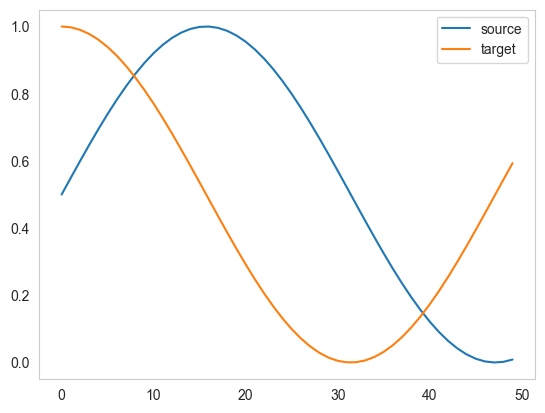

In [11]:
def compute_discrepancy(source0, target0, weights=None):
    weights = np.ones(len(source0)) if weights is None else weights
    source = weights * source0
    target = weights * target0
    dif = source - target
    reg = get_regions(dif)
    top = np.array([max([i,j]) for i,j in zip(source,target)])
    tot_disc = dif.sum()/float(target.sum())
    disc=[]
    for (i,j,s) in reg:
        d = dif[i:j].sum() / float(top[i:j].sum())
        disc += [(i,j,d)]
    return tot_disc, disc

src = 0.5*(1 + np.sin(np.arange(0,5,0.1)))
trg = 0.5*(1 + np.cos(np.arange(0,5,0.1)))
discr = compute_discrepancy(src, trg)
print (discr)
plt.plot(src, label="source")
plt.plot(trg, label="target")
plt.legend(loc="best")

In [12]:
mu_pop = cities['profiles']['pop'][0]
mu_lum = cities['profiles']['lum'][0]

# Identify nan values and filter them out
nan_indices_pop = np.isnan(mu_pop)
nan_indices_lum = np.isnan(mu_lum)

# Filter out nan values from both arrays
mu_pop = mu_pop[~nan_indices_pop]
mu_lum = mu_lum[~nan_indices_lum]

mu_pop = mu_pop/mu_pop.max()
mu_lum = mu_lum/mu_lum.max()


dis_lum, dis_lum_reg = compute_discrepancy(mu_lum, mu_pop)

print (dis_lum)
print (dis_lum_reg)

4.288959486931389
[(0, 87, 0.8094538300062755)]
